## OASIS Brain Segmentation with and Improved UNet

### Dhilan Singh (44348724)

In [1]:
import tensorflow as tf
import glob

print('Tensorflow Version:', tf.version.VERSION)

# Download the dataset (use the direct link given on the page)
print("> Loading images ...")
# tf.keras.utils.get file downloads a file from a URL if it not already in the cache.
#     origin: Original URL of the file.
#     fname: Name of the file. If an absolute path /path/to/file.txt is specified the 
#            file will be saved at that location (in cache directory).
#            NEEDS FILE EXTENSION TO WORK!!!
#     extract: If true, extracting the file as an Archive, like tar or zip.
#     archive_format: zip, tar, etc...
#     returns: Path to the downloaded file.
dataset_url = "https://cloudstor.aarnet.edu.au/plus/s/n5aZ4XX1WBKp6HZ/download"
data_path = tf.keras.utils.get_file(origin=dataset_url,
                                    fname="keras_png_slices_data.zip",
                                    extract=True,
                                    archive_format="zip")

# Remove the .zip file extension from the data path
data_path_clean = data_path.split('.zip')[0]

# Load filenames into a list in sorted order
train_images = sorted(glob.glob(data_path_clean + "/keras_png_slices_train/*.png"))
train_masks = sorted(glob.glob(data_path_clean +"/keras_png_slices_seg_train/*.png"))
val_images = sorted(glob.glob(data_path_clean + "/keras_png_slices_validate/*.png"))
val_masks = sorted(glob.glob(data_path_clean + "/keras_png_slices_seg_validate/*.png"))
test_images = sorted(glob.glob(data_path_clean + "/keras_png_slices_test/*.png"))
test_masks = sorted(glob.glob(data_path_clean + "/keras_png_slices_seg_test/*.png"))

# Build tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

# Make the dataset to be reshuffled each time it is iterated over.
# This is so that we get different batches for each epoch.
# For perfect shuffling, the buffer size needs to be greater than or equal to 
# the size of the dataset.
train_ds = train_ds.shuffle(len(train_images))
val_ds = val_ds.shuffle(len(val_images))
test_ds = test_ds.shuffle(len(test_images))

def decode_png(file_path):
    """
    Decode raw data from filenames into png image with
    the desired channels and size.

    @param: file_path:
        The full path of the image file.
    @returns:
        png image with 1 channel (grayscale) and size 256x256.

    Reference: Adapted from Siyu lu
    """
    # Load the raw data from the file as a string
    png = tf.io.read_file(file_path)
    # Convert the compressed string to a uint8 tensor.
    # channels=3 for RGB, channels=1 for grayscale
    png = tf.image.decode_png(png, channels=1)
    # Resize the image to the desired size (size of network).
    png = tf.image.resize(png, (256, 256))
    return png

def process_path(image_fp, mask_fp):
    """
    Preprocess an image and segmentation mask pair from file paths.
    Normalizes the images and pixel-wise one-hot encodes the 
    segmentation masks.

    @param: image_fp:
       Path to the image file.
    @param: mask_fp:
        Path to the mask file.
    @returns:
        Normalized image (256x256x1) and one-hot encoded segmentation mask,
        (256x256x4) as png images.
    """
    # Get image as a tensor with channels
    image = decode_png(image_fp)
    # Standardise values to be in the [0, 1] range (only for images) (IMPORTANT).
    # If were using a GAN, then would make sense to normalise the target images as well.
    image = tf.cast(image, tf.float32) / 255.0
    
    # Get mask as a tensor with channels
    mask = decode_png(mask_fp)
    # One-hot encode each pixel of the mask.
    # From np.unique(mask) get => [0, 85, 170, 255], which are
    # the pixel classes of the segmentation. We want to map these
    # from these pixel values to our class values (1, 2, 3, 4), i.e.
    # mask[mask==0] = 0 (Background)
    # mask[mask==85] = 1 (CSF)
    # mask[mask==170] = 2 (Gray matter)
    # mask[mask=255] = 3 (White matter)
    mask = mask == [0, 85, 170, 255]
    
    return image, mask

# Use Dataset.map to apply preprocessing transformation.
# Normalize the images and pixel-wise one-hot encode the segmentation masks.
print("> Preprocessing images ...")
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)
test_ds = test_ds.map(process_path)

Tensorflow Version: 2.1.0
> Loading images ...
> Preprocessing images ...


In [5]:
# Input Image Parameters for model
image_pixel_rows = 256 
image_pixel_cols = 256
image_channels = 1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, ReLU, LeakyReLU, Conv2D, BatchNormalization, Flatten, Dense, Dropout, UpSampling2D, concatenate, Add
from tensorflow_addons.layers import InstanceNormalization

# Activation used throughout, with negative slope of 10^-2 
leakyReLu = LeakyReLU(alpha=1e-2)
# Use dropout rate of 0.3 throughout
dropout_rate = 0.3

def conv2D_layer(input_layer, 
                 n_filters, 
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 activation=leakyReLu, 
                 use_bias=True,
                 kernel_initializer='he_normal',
                 batch_normalization=False,
                 instance_normalization=False,
                **kwargs):
    """
    Create a 2D convolutional layer with normalization.

    @param input_layer:
        The input layer.
    @param n_filters:
        The number of filters.
    @param kernel_size:
        The size of the kernel filter.
    @param strides:
        The stride number during convolution.
    @param activation:
        Keras activation layer to use.
    @param batch_normalization:
        If true, apply batch normalization.
    @param instance_normalization:
        If true, apply instance normalization.

    Reference: Adapted from Shakes lecture code layers.py
    """
    # Create a 2D convolution layer 
    conv_layer = Conv2D(n_filters, 
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        activation=None,
                        use_bias=use_bias,
                        kernel_initializer=kernel_initializer, 
                        **kwargs)(input_layer)
    
    # Apply chosen normalization method
    if batch_normalization:
        # Apply Batch normalization layer 
        norm_layer = BatchNormalization()(conv_layer)
    elif instance_normalization:
        # Apply Instance normalization
        norm_layer = InstanceNormalization()(conv_layer)

    # Activation function
    layer = Activation(activation=activation)(norm_layer)
    
    return layer


def context_module(input, n_filters, activation=leakyReLu):
    """
    The activations in the context pathway are computed by context modules.
    Each context module is a pre-activation residual block with two
    3x3x convolutional layers and a dropout layer (pdrop = 0.3) in between.
    """
    conv1 = conv2D_layer(input, n_filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, instance_normalization=True)
    dropout = Dropout(rate=dropout_rate)(conv1)
    conv2 = conv2D_layer(dropout, n_filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, instance_normalization=True)
    return conv2

def upsampling_module(input, n_filters, activation=leakyReLu):
    """
    Upsampling the low resolution feature maps, is done by means of a simple 
    upscale that repeats the feature voxels twice in each spatial dimension, 
    followed by a 3x3 convolution that halves the number of feature maps. 
    Compared to the more frequently employed transposed convolution this 
    approach delivers similar performance while preventing checkerboard
    artifacts in the network output.
    """
    up_sample = UpSampling2D(size=(2,2))(input)
    conv1 = conv2D_layer(up_sample, n_filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, instance_normalization=True)
    return conv1

def localization_module(input, n_filters, activation=leakyReLu):
    """
    A localization module consists of a 3x3 convolution followed by a 1x1 
    convolution that halves the number of feature maps of the input.
    """
    conv1 = conv2D_layer(input, n_filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, instance_normalization=True)
    conv2 = conv2D_layer(conv1, n_filters, kernel_size=(1, 1), strides=(1, 1), activation=activation, instance_normalization=True)
    return conv2

# improved unet model
def improved_unet_model(output_channels, n_filters=16, 
                        input_size=(image_pixel_rows, image_pixel_cols, image_channels)):
    """
    Improved UNet network based on https://arxiv.org/abs/1802.10508v1.

    Comprises of a context aggregation pathway that encodes increasingly abstract 
    representations of the input as we progress deeper into the network, followed 
    by a localization pathway that recombines these representations with shallower 
    features to precisely localize the structures of interest.


    output_channels: Correspond to the classes a pixel can be. Here 4.
    f: Initial number of filters used in convolutional layers. Starts at 16.
    
    Reference: https://arxiv.org/abs/1802.10508v1
    """
    # Input Image
    inputs = Input(shape=input_size)

    # Context Pathway Level 1
    conv1 = conv2D_layer(inputs, n_filters, kernel_size=(3, 3), strides=(1, 1), activation=leakyReLu, instance_normalization=True)
    context1 = context_module(conv1, n_filters)
    rescon1 = Add()([conv1, context1])

    # Context Pathway Level 2
    down_conv1 = conv2D_layer(rescon1, 2*n_filters, kernel_size=(3, 3), strides=(2, 2), activation=leakyReLu, instance_normalization=True)
    context2 = context_module(down_conv1, 2*n_filters)
    rescon2 = Add()([down_conv1, context2])

    # Context Pathway Level 3
    down_conv2 = conv2D_layer(rescon2, 4*n_filters, kernel_size=(3, 3), strides=(2, 2), activation=leakyReLu, instance_normalization=True)
    context3 = context_module(down_conv2, 4*n_filters)
    rescon3 = Add()([down_conv2, context3])

    # Context Pathway Level 4
    down_conv3 = conv2D_layer(rescon3, 8*n_filters, kernel_size=(3, 3), strides=(2, 2), activation=leakyReLu, instance_normalization=True)
    context4 = context_module(down_conv3, 8*n_filters)
    rescon4 = Add()([down_conv3, context4])

    # Context Pathway Level 5 (Base Part 1)
    down_conv4 = conv2D_layer(rescon4, 16*n_filters, kernel_size=(3, 3), strides=(2, 2), activation=leakyReLu, instance_normalization=True)
    context5 = context_module(down_conv4, 16*n_filters)
    rescon5 = Add()([down_conv4, context5])

    # Localization Pathway Level 5 (Base Part 2)
    up_sample5 = upsampling_module(rescon5, 8*n_filters)

    # Localization Pathway Level 4
    skip4 = concatenate([up_sample5, rescon4])
    localize4 = localization_module(skip4, 8*n_filters)
    up_sample4 = upsampling_module(localize4, 4*n_filters)
    
    # Localization Pathway Level 3
    skip3 = concatenate([up_sample4, rescon3])
    localize3 = localization_module(skip3, 4*n_filters)
    up_sample3 = upsampling_module(localize3, 2*n_filters)
    # Segmentation Layer 3 (At 1/4 of the size of original image)
    seg_map_3 = conv2D_layer(localize3, output_channels, kernel_size=(1, 1), strides=(1, 1), activation=leakyReLu, instance_normalization=True)
    seg_map_3_upscale = UpSampling2D(interpolation='bilinear')(seg_map_3)

    # Localization Pathway Level 2
    skip2 = concatenate([up_sample3, rescon2])
    localize2 = localization_module(skip2, 2*n_filters)
    up_sample2 = upsampling_module(localize2, n_filters)
    # Segmentation Layer 2 (At 1/2 of the size of original image)
    seg_map_2 = conv2D_layer(localize2, output_channels, kernel_size=(1, 1), strides=(1, 1), activation=leakyReLu, instance_normalization=True)
    # Add the upscaled segmentation layer 3 to segmentation layer 2
    seg_map_3_2 = Add()([seg_map_3_upscale, seg_map_2])
    seg_map_3_2_upscale = UpSampling2D(interpolation='bilinear')(seg_map_3_2)

    # Localization Pathway Level 1
    skip1 = concatenate([up_sample2, rescon1])
    conv_out = conv2D_layer(skip1, 2*n_filters, kernel_size=(3, 3), strides=(1, 1), activation=leakyReLu, instance_normalization=True)
    # Segmentation Layer 1 (At the same size of original image)
    seg_map_1 = conv2D_layer(conv_out, output_channels, kernel_size=(1, 1), strides=(1, 1), activation=leakyReLu, instance_normalization=True)
    # Add the upscaled segmentation sum of layer 3 and 2 to segmentation layer 1
    seg_map_full = Add()([seg_map_3_2_upscale, seg_map_1])

    if output_channels > 2:
        # Multiclass classification, so use softmax to output class predctions that
        # sum to 1 (i.e. probabilities).
        outputs = Activation('softmax')(seg_map_full)
    else:
        # Problem involves binary classification of pixels, so can use a sigmoid (0 or 1).
        outputs = Activation('sigmoid')(seg_map_full)
    
    # Complete Model
    return Model(inputs=inputs, outputs=outputs)

from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=0.1):
    """
    The Dice Similarity Coefficient (DSC) is a statistical tool used to measure
    the similarities between two sets of data. Most broadly used tool in the 
    validation of image segmentation algorithms.

    Given two sets X and Y,
        DSC = (2*|X intersection with Y|) / (|X| + |Y|)
        
        Where the vertical bars refers to the cardinality of the set, i.e. the 
        number of elements in that set, e.g. |X| means the number of elements in set X.
        The intersection of two sets is just the multiplication of them. So this is
        really twice the number of elements common to both sets divided by the sum 
        of the number of elements in each set.
    
    @param y_true:
        A one-hot encoding of the ground truth segmentation map. Ground truth (actual)
        image segmentation.
    @param y_pred:
        Softmax output of the network. Predicted image segmentation.
    @param smooth:
        Dummy number to prevent division by zero.
    @returns:
        Dice coefficient, between 0 and 1. Used as a metric.
    """
    # Change the dimension to one (pixels in image)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculation for the loss function
    intersection = K.sum(tf.cast(y_true_f, tf.float32) * tf.cast(y_pred_f, tf.float32))
    return (tf.cast(2., tf.float32) * tf.cast(intersection + smooth, tf.float32)) / (K.sum(tf.cast(y_true_f, tf.float32)) + K.sum(tf.cast(y_pred_f, tf.float32)) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    """
    Dice similarity coefficient loss. Returns the distance between the ground
    truth segmentation and the predicted segmentation. Used as a loss function 
    for training.

        Loss = 1 - DSC
    
    @param y_true:
        A one-hot encoding of the ground truth segmentation map. Ground truth (actual)
        image segmentation.
    @param y_pred:
        Softmax output of the network. Predicted image segmentation.
    @returns:
        Dice coefficient loss (distance), between 0 and 1. Used as a loss function.
    """
    return 1. - dice_coefficient(y_true, y_pred)




# Create Improved UNet Model
print("> Building Model ...")
model = improved_unet_model(4, n_filters=16, input_size=(image_pixel_rows, image_pixel_cols, image_channels))

# Compile Model using DSC as loss function and a metric
model.compile(optimizer='adam',
              loss=dice_coefficient_loss,
              metrics=['accuracy', dice_coefficient])
model.summary()

> Building Model ...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_58 (Inst (None, 256, 256, 16) 32          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 256, 256, 16) 0           instance_normalization_58[0][0]  
_______________________________________________________________________

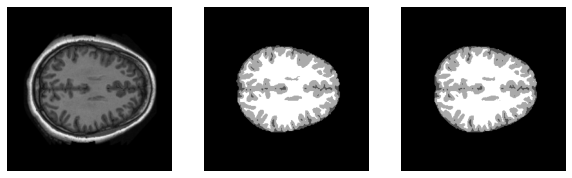

302/302 [==============================] - 405s 1s/step - loss: 0.0401 - accuracy: 0.9876 - dice_coefficient: 0.9599 - val_loss: 0.0313 - val_accuracy: 0.9894 - val_dice_coefficient: 0.9687
End


In [6]:
import matplotlib.pyplot as plt

def display(display_list):
    """
    Plotting function.
    """
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(ds, num=1):
    for image, mask in ds.take(num):
        pred_mask = model.predict(image[tf.newaxis, ...])
        pred_mask = tf.argmax(pred_mask[0], axis=-1)
        display([tf.squeeze(image), tf.argmax(tf.cast(mask, tf.uint8), axis=-1), pred_mask])


BATCH_SIZE = 12
EPOCHS = 8

from IPython.display import clear_output

# Fill in some of the blank by default callback functions
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(val_ds)
    # can fill in another function on_epoch_start() if need
    # to perform some action at the start of an epoch.

history = model.fit(train_ds.batch(BATCH_SIZE), epochs=EPOCHS,
                    validation_data=val_ds.batch(BATCH_SIZE),
                    callbacks=[DisplayCallback()])




# End of operation
print('End')

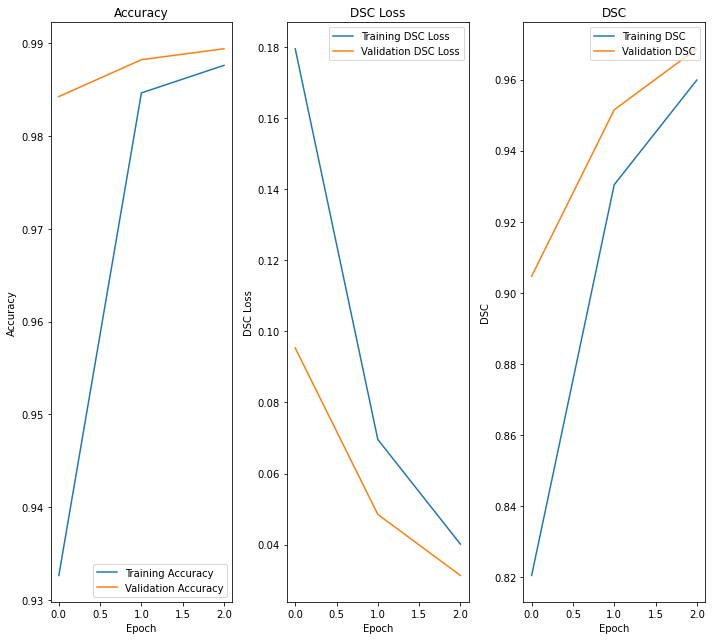

<Figure size 432x288 with 0 Axes>

In [20]:
import os

train_output_dir = "training_output/"
os.makedirs(train_output_dir, exist_ok=True)


# Obtain training and validation accuracy and DSC Loss and DSC
# Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# DSC Loss
train_DSC_loss = history.history['loss']
val_DSC_loss = history.history['val_loss']
# DSC
train_DSC = history.history['dice_coefficient']
val_DSC = history.history['val_dice_coefficient']

epochs_range = range(EPOCHS)

# Plot the training and valdation accuracy over training
plt.figure(figsize=(10, 9))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

# Plot the training and valdation DSC loss over training
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_DSC_loss, label='Training DSC Loss')
plt.plot(epochs_range, val_DSC_loss, label='Validation DSC Loss')
plt.xlabel('Epoch')
plt.ylabel('DSC Loss')
#plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('DSC Loss')

# Plot the training and valdation DSC over training
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_DSC, label='Training DSC')
plt.plot(epochs_range, val_DSC, label='Validation DSC')
plt.xlabel('Epoch')
plt.ylabel('DSC')
#plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('DSC')

# Show and save plots as a png
plt.tight_layout()
plt.show()
plt.savefig(train_output_dir + "plots.png")

In [22]:
# Evaluate trained model on the test set
print("> Evaluating Trained Model on Test Set ...")
test_DSC_loss, test_acc, test_DSC = model.evaluate(test_ds.batch(BATCH_SIZE), verbose=1)


Test Set Results:

302/302 [==============================] - 161s 533ms/step - loss: 0.0316 - accuracy: 0.9891 - dice_coefficient: 0.9684


In [26]:
print("----- Test Set Results -----")
print("DSC Loss: ", test_DSC_loss)
print("DSC: ", test_DSC)
print("Accuracy: ", test_acc)

----- Test Set Results -----
DSC Loss:  0.0316132784679236
DSC:  0.9683864
Accuracy:  0.9891029


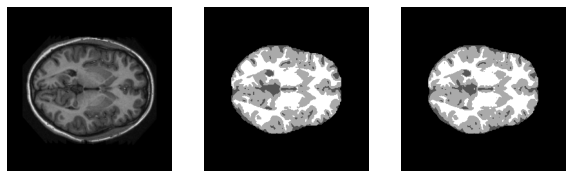

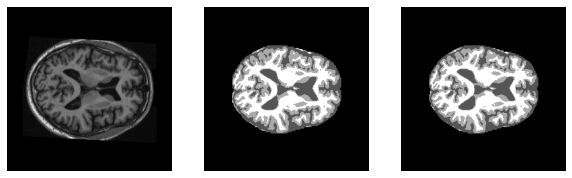

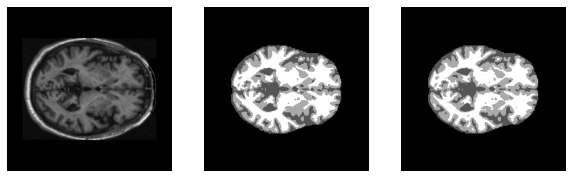

In [28]:
# Show some test set predictions
show_predictions(test_ds, 3)

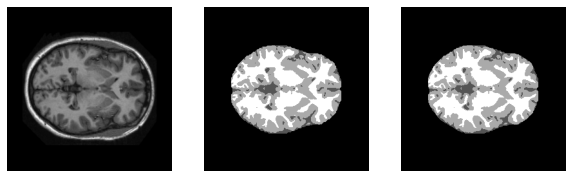

<Figure size 432x288 with 0 Axes>

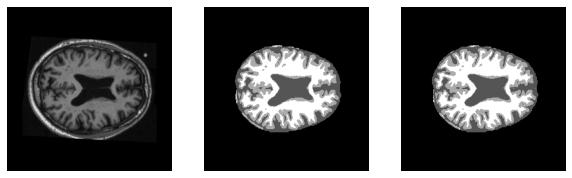

<Figure size 432x288 with 0 Axes>

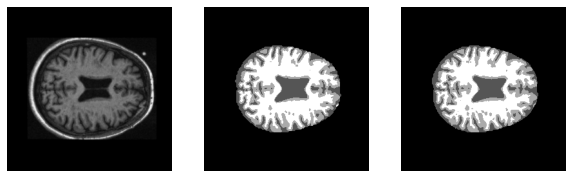

<Figure size 432x288 with 0 Axes>

In [32]:
# Make new folder in current working directory to store testing outputs
test_output_dir = "testing_output/"
os.makedirs(test_output_dir, exist_ok=True)

def save_predictions(model, ds, num=1):
    """
    Uses model to predict and plot the segmentation results of a dataset.
    Save to folder.

    @param ds:
        Tensorflow Dataset.
    @param num:
        Number of predictions to make using dataset. Defaults to 1.

    Reference: Adapted from Siyu Liu's tutorial code.
    """
    counter = 0
    for image, mask in ds.take(num):
        pred_mask = model.predict(image[tf.newaxis, ...])
        pred_mask = tf.argmax(pred_mask[0], axis=-1)
        disp_list = [tf.squeeze(image), tf.argmax(tf.cast(mask, tf.uint8), axis=-1), pred_mask]
        
        plt.figure(figsize=(10, 10))
        for i in range(len(disp_list)):
            plt.subplot(1, len(disp_list), i+1)
            plt.imshow(disp_list[i], cmap='gray')
            plt.axis('off')
        
        plt.show()
        plt.savefig(test_output_dir + "visualisation" + str(counter) + ".png")

        counter = counter + 1
        
save_predictions(model, test_ds, 3)